In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

cleaned_raw_data_url = 'https://raw.githubusercontent.com/qkma-umich/milestone2_team18/refs/heads/main/data.csv'
df = pd.read_csv(cleaned_raw_data_url, index_col=0)
df.set_index('Date', inplace=True)

Exploratory Data Analysis

Box plot comparing 5 day volatility distribution across sectors

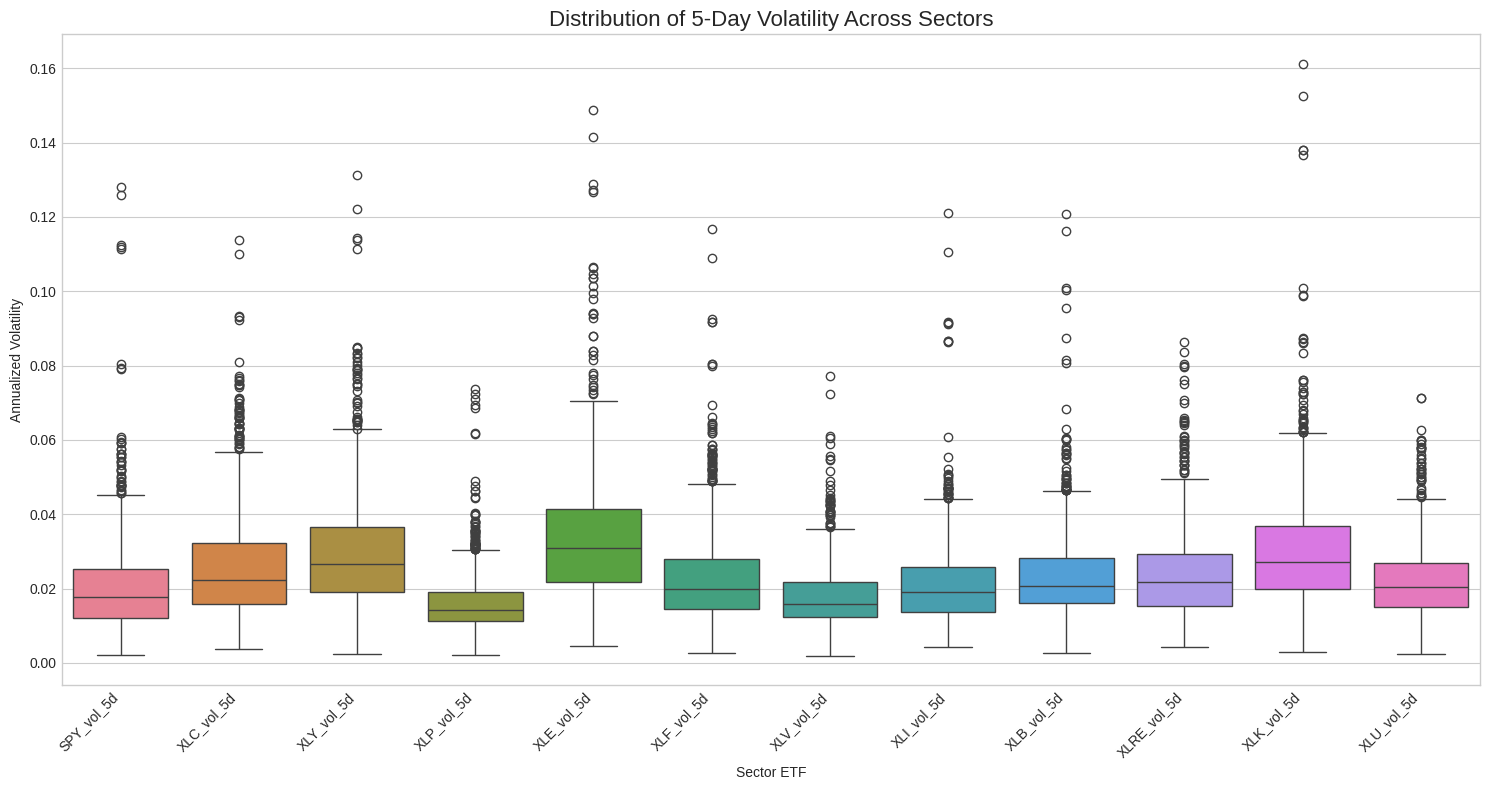

In [61]:
vol_cols = [col for col in df.columns if col.endswith('_vol_5d')]
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[vol_cols])
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of 5-Day Volatility Across Sectors', fontsize=16)
plt.ylabel('Annualized Volatility')
plt.xlabel('Sector ETF')
plt.tight_layout()
plt.show()

Scatter plot comparing Log of vix to 5 day realized volatility

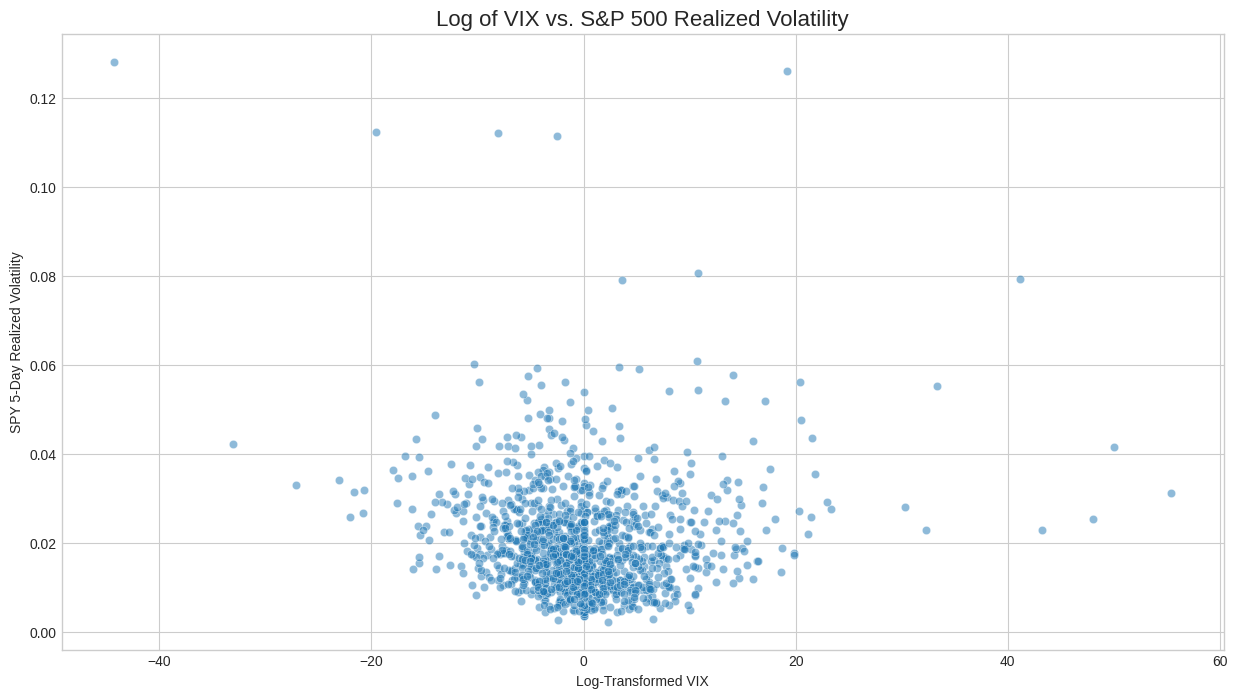

In [62]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='VIX_log', y='SPY_vol_5d', alpha=0.5)
plt.title('Log of VIX vs. S&P 500 Realized Volatility', fontsize=16)
plt.xlabel('Log-Transformed VIX')
plt.ylabel('SPY 5-Day Realized Volatility')
plt.grid(True)
plt.show()

Auto correlation plot to visualize volatility clustering

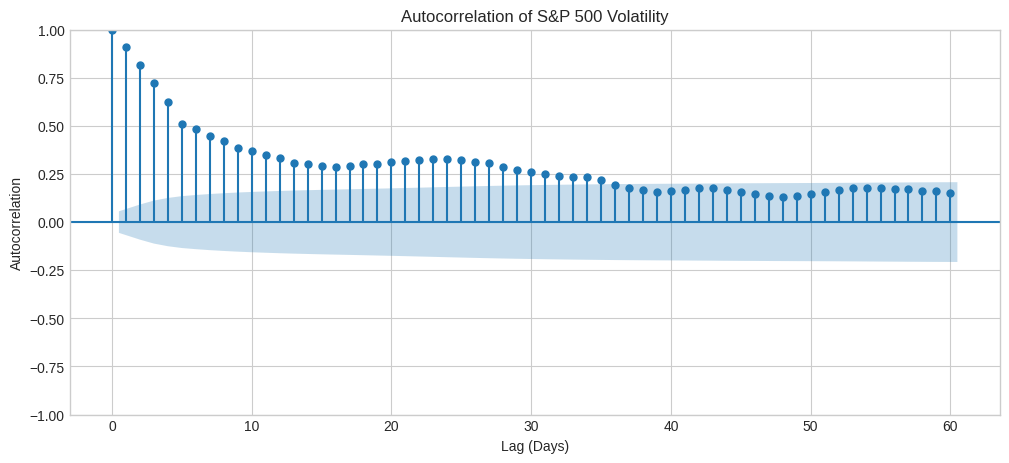

In [63]:
from statsmodels.graphics.tsaplots import plot_acf

spy_vol = df['SPY_vol_5d']


fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(spy_vol, lags=60, ax=ax) # lags=60 shows correlation up to 60 days (approx. 3 months)
ax.set_title('Autocorrelation of S&P 500 Volatility')
ax.set_xlabel('Lag (Days)')
ax.set_ylabel('Autocorrelation')
plt.show()

XGBoost Model

In [64]:
# Selected feature names of external variables
feature_names = ['VIX', 'VIX_log', 'Overnight Rate', '1-Month Rate', '3-Month Rate', 'Unemployment Rate', 'CPI_pct_change', 'PPI_pct_change', 'GDP_pct_change']

# Testing to align top 3 most correlated external variables to match up with GARCHX
# feature_names = ['VIX', 'CPI_pct_change', 'GDP_pct_change']
X = df[feature_names]
y = df["SPY_vol_5d"]

# Split the data into training and testing sets, set shuffle to false due to time series data
train_test_split_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_test_size, random_state=42, shuffle=False)

Param Tuning

In [65]:
tscv_tune = TimeSeriesSplit(n_splits=5)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv_tune,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X, y)
print("Best Params:", grid.best_params_)
print("Best RMSE:", (-grid.best_score_)**0.5)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best RMSE: 0.01067855242138676


In [66]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_train_nocv = xgb_model.predict(X_train)
y_pred_test_nocv = xgb_model.predict(X_test)
print("XGB Model\nR^2 with training data with No Cross Validation\nR-Squared:", r2_score(y_train, y_pred_train_nocv))
print("\nModel Performance on Prediction with No Cross Validation\nMAE:", mean_absolute_error(y_test, y_pred_test_nocv), "\nRMSE:", root_mean_squared_error(y_test, y_pred_test_nocv))

XGB Model
R^2 with training data with No Cross Validation
R-Squared: 0.784899037522054

Model Performance on Prediction with No Cross Validation
MAE: 0.007220864301739857 
RMSE: 0.013746417081899356


In [67]:
# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
xgb_r2_scores = []
xgb_mae_scores = []
xgb_rmse_scores = []
xgb_y_test_dict = {}
xgb_y_pred_dict = {}

for j, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
    )

    xgb_model.fit(X_train, y_train)
    y_pred_train_tscv = xgb_model.predict(X_train)
    y_pred_test_tscv = xgb_model.predict(X_test)
    print("XGB Model Time Series Cross Validation", j)

    xgb_r2 = r2_score(y_train, y_pred_train_tscv)
    xgb_mae = mean_absolute_error(y_test, y_pred_test_tscv)
    xgb_rmse = root_mean_squared_error(y_test, y_pred_test_tscv)

    xgb_r2_scores.append(xgb_r2)
    xgb_mae_scores.append(xgb_mae)
    xgb_rmse_scores.append(xgb_rmse)
    xgb_y_test_dict[j] = y_test
    xgb_y_pred_dict[j] = y_pred_test_tscv

    print("R^2:", xgb_r2)
    print("MAE", xgb_mae)
    print("RMSE", xgb_rmse, "\n")

XGB Model Time Series Cross Validation 0
R^2: 0.7970958528491873
MAE 0.010172013956782208
RMSE 0.013042516288442822 

XGB Model Time Series Cross Validation 1
R^2: 0.8882077304293711
MAE 0.007802067699063644
RMSE 0.009855565521183817 

XGB Model Time Series Cross Validation 2
R^2: 0.8107067469761258
MAE 0.005755099179865712
RMSE 0.007098401635817557 

XGB Model Time Series Cross Validation 3
R^2: 0.7908955745338323
MAE 0.004392882890917877
RMSE 0.005700921651299631 

XGB Model Time Series Cross Validation 4
R^2: 0.7689418050059039
MAE 0.007455817416122122
RMSE 0.014833414736575236 



In [68]:
print("XGB Model Performance Mean")
print("R^2:", np.mean(xgb_r2_scores))
print("MAE:", np.mean(xgb_mae_scores))
print("RMSE:", np.mean(xgb_rmse_scores))

XGB Model Performance Mean
R^2: 0.8111695419588841
MAE: 0.007115576228550312
RMSE: 0.010106163966663811


Graphs to compare prediction performance

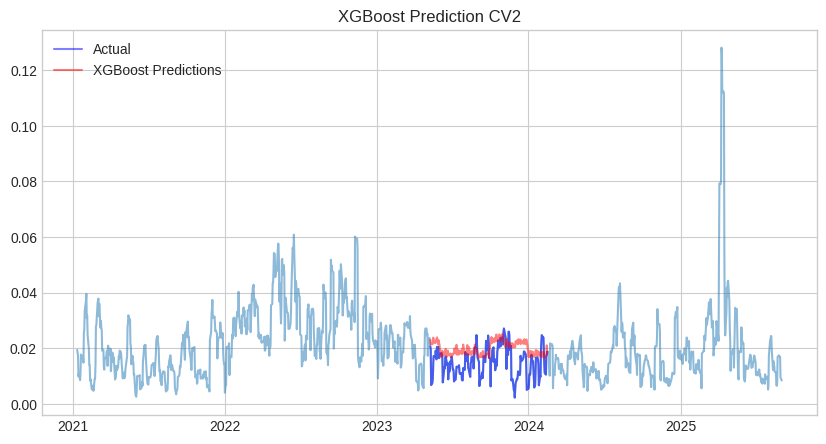

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(xgb_y_test_dict.get(2).index), xgb_y_test_dict.get(2), color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(xgb_y_test_dict.get(2).index), xgb_y_pred_dict.get(2), color='red', label='XGBoost Predictions', alpha=0.5)
plt.title("XGBoost Prediction CV2")
plt.legend()
plt.show()

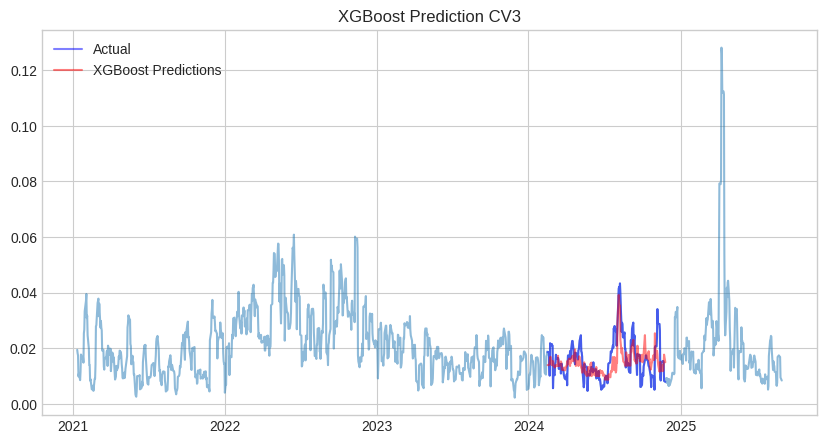

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(xgb_y_test_dict.get(3).index), xgb_y_test_dict.get(3), color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(xgb_y_test_dict.get(3).index), xgb_y_pred_dict.get(3), color='red', label='XGBoost Predictions', alpha=0.5)
plt.title("XGBoost Prediction CV3")
plt.legend()
plt.show()

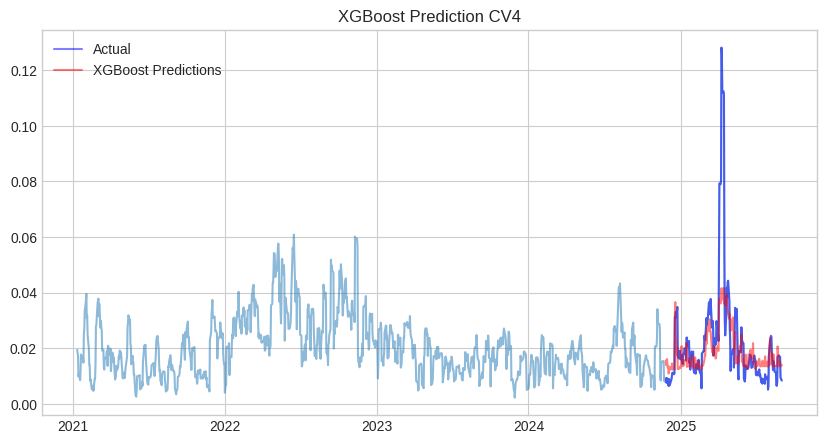

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(xgb_y_test_dict.get(4).index), xgb_y_test_dict.get(4), color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(xgb_y_test_dict.get(4).index), xgb_y_pred_dict.get(4), color='red', label='XGBoost Predictions', alpha=0.5)
plt.title("XGBoost Prediction CV4")
plt.legend()
plt.show()